In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import seaborn as sns
import cv2
import glob
import os

In [2]:
keras.utils.set_random_seed(42)

In [3]:
img_dir = "dataset/train/"
img_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')]
print(f"Total images: {len(img_files)}")

Total images: 10000


Dimensions of the first image: (27, 48, 3)


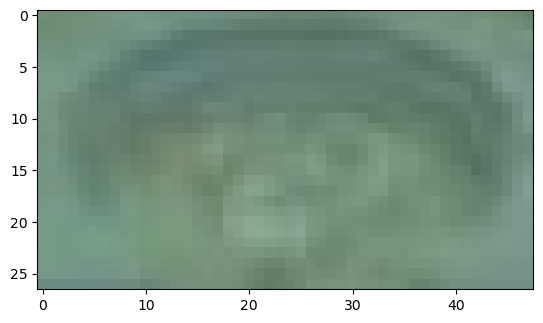

In [4]:
# Загрузка и отображение первого изображения для проверки
first_img = cv2.imread(img_files[0])
print(f"Dimensions of the first image: {first_img.shape}")
plt.imshow(cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB))

In [5]:
# Разделение на обучающую и тестовую выборки
train_files, test_files = train_test_split(img_files, test_size=0.2, random_state=42)

In [6]:
def preprocess_img(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [48, 48])
    image = image / 255.0 
    return image

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(preprocess_img)
train_dataset = tf.data.Dataset.zip((train_dataset, train_dataset)).shuffle(1000).batch(256).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(test_files)
test_dataset = test_dataset.map(preprocess_img)
test_dataset = tf.data.Dataset.zip((test_dataset, test_dataset)).shuffle(1000).batch(256).prefetch(tf.data.AUTOTUNE)

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 32
Test dataset length: 8


In [8]:
def img_transform(path_list):
    transformed_imgs = []
    for path in path_list:
        transformed_imgs.append(preprocess_img(path))
    return np.stack(transformed_imgs)

In [9]:
df_test_annotations = pd.read_csv("dataset/test/test_annotation.txt", sep=" ", header=None, names=['image', 'label'])
df_test_annotations['image'] = df_test_annotations['image'].apply(lambda x: os.path.join("dataset/test/imgs/", x))

# Преобразование тестовых изображений
test_images = img_transform(df_test_annotations['image'].values)
print(df_test_annotations.head())

# Загрузка данных о разливе
spill_img_paths = glob.glob("dataset/proliv/*.jpg")
print(f"Total spill images: {len(spill_img_paths)}")

# Преобразование изображений разлива
spill_data_transformed = img_transform(spill_img_paths)

                                               image  label
0  dataset/test/imgs/b9bc8d6d-0cb6-40c2-a38d-61b4...      0
1  dataset/test/imgs/9d3893a3-c877-4873-81c5-91aa...      0
2  dataset/test/imgs/4f5cef60-bf06-4daf-be8d-a36b...      0
3  dataset/test/imgs/37ee27b2-89a3-4b66-98a4-fb39...      0
4  dataset/test/imgs/43543d1a-24b6-4018-af56-27fe...      0
Total spill images: 154


In [10]:
input_layer = layers.Input(shape=(48, 48, 3))

# Блок свёртки и подвыборки
conv1 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
conv2 = layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', strides=2)(conv1)
conv3 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu')(conv2)
conv4 = layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', strides=2)(conv3)
conv5 = layers.Conv2D(128, kernel_size=(3, 3), padding='same')(conv4)
conv6 = layers.Conv2D(128, kernel_size=(3, 3), padding='same', strides=2)(conv5)
conv7 = layers.Conv2D(128, kernel_size=(3, 3), padding='same')(conv6)

# Блоки апсемплинга
up1 = layers.UpSampling2D(2)(conv7)
conv8 = layers.Conv2D(64, kernel_size=(3, 3), padding='same')(up1)
up2 = layers.UpSampling2D(2)(conv8)
conv9 = layers.Conv2D(32, kernel_size=(3, 3), padding='same')(up2)
up3 = layers.UpSampling2D(2)(conv9)

# Выходной слой
output_layer = layers.Conv2D(3, kernel_size=(3, 3), padding='same', activation='sigmoid')(up3)

model_arch = models.Model(input_layer, output_layer)
model_arch.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 527,715 (2.01 MB)

 Trainable params: 527,715 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_arch.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())

history = model_arch.fit(
    train_dataset, 
    epochs=5, 
    validation_data=test_dataset, 
    callbacks=[tf.keras.callbacks.TensorBoard(log_dir='logs/experiment_1')]
)

Epoch 1/5
11/32 ━━━━━━━━━━━━━━━━━━━━ 10s 485ms/step - loss: 0.0050

In [ ]:
model_arch.evaluate(test_dataset)

In [ ]:
# Создание DataFrame с историей обучения
history_data = pd.DataFrame(history.history)

plt.figure(figsize=(10, 6))

plt.plot(history_data['loss'], label='Training Loss', color='navy', linewidth=2)
plt.plot(history_data['val_loss'], label='Validation Loss', color='skyblue', linewidth=2)
plt.title('Model Loss Evolution', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In [ ]:
# Предсказание для выбранного изображения из обучающего набора
sample_img = np.expand_dims(preprocess_img(train_files[10]), 0)
predicted_img = model_arch.predict(sample_img)

# Визуализация оригинального и обработанного изображения
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_img[0])
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(predicted_img[0])
ax[1].set_title('Transformed Image')
ax[1].axis('off')

spill_img_paths = glob.glob("data/spill_data/*.jpg")
print(f"Total spill images: {len(spill_img_paths)}")

In [ ]:
spill_sample = np.expand_dims(preprocess_img(spill_img_paths[130]), 0)
predicted_spill = model_arch.predict(spill_sample)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(spill_sample[0])
ax[0].set_title('Original Spill Image')
ax[0].axis('off')
ax[1].imshow(predicted_spill[0])
ax[1].set_title('Processed Spill Image')
ax[1].axis('off')

# Вычисление среднеквадратичной ошибки для изображения разлива
mse_value = np.mean(np.square(spill_sample - predicted_spill))
print(f"MSE = {mse_value}")

In [ ]:
spill_data = img_transform(spill_img_paths)
spill_predictions = model_arch.predict(spill_data)

mse_spill = np.mean(np.square(spill_data - spill_predictions))
print(f"MSE for spill data: {mse_spill}")

In [ ]:
original_images = img_transform(spill_img_paths[:1000])

spill_data = img_transform(spill_img_paths)
spill_predictions = model_arch.predict(spill_data)

# Вычисление среднеквадратичной ошибки (MSE) для данных о разливе
mse_spill = np.mean(np.square(spill_data - spill_predictions))
print(f"MSE for spill data: {mse_spill}")

# Загрузка небольшого набора оригинальных изображений для оценки
original_images = img_transform(spill_img_paths[:1000])

# Вычисление MSE для оригинальных изображений
mse_list_original = []
for original_img in original_images:
    prediction = model_arch.predict(np.expand_dims(original_img, axis=0), verbose=0)
    mse_list_original.append(np.mean(np.square(original_img - prediction)))

# Вычисление среднего значения MSE для оригинальных изображений
mse_original = np.mean(mse_list_original)
print(f"MSE for original images: {mse_original}")

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='mse', data=mse_data)
plt.title('Распределение MSE между оригинальными изображениями и изображениями разлива', fontsize=16)
plt.xlabel('Класс', fontsize=14)
plt.ylabel('MSE', fontsize=14)
plt.xticks([0, 1], ['Оригинальные', 'Разлив'])
plt.show()

In [ ]:
mse_data['mse'] *= 100

# Обучение модели
model_tree = DecisionTreeClassifier(max_depth=1, criterion='entropy')
model_tree.fit(mse_data.drop(columns='class'), mse_data['class'])

# Визуализация дерева решений
fig, ax = plt.subplots(figsize=(10, 10))
plot_tree(model_tree, feature_names=['mse'], class_names=['Class 0', 'Class 1'], filled=True, ax=ax)

# Установка порога
threshold = 0.213

# Функция для вычисления TPR и FPR
def evaluate_performance(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = tn / (tn + fp)
    return tpr, fpr

# Функция для получения предсказаний на основе порога
def get_predictions(imgs, preds, threshold):
    mse_values = np.mean(np.square(imgs - preds), axis=1)
    return (mse_values >= threshold).astype(int)

preds = model_arch.predict(test_images)

# Применение порога и вычисление показателей
threshold /= 100
df_test_annotations['predicted'] = get_predictions(test_images, preds, threshold=threshold)

# Вычисление и вывод результатов
tpr, fpr = evaluate_performance(df_test_annotations['class'], df_test_annotations['predicted'])
print(f"TPR = {tpr:.3f}, FPR = {fpr:.3f}, MSE_threshold = {threshold:.3f}")


In [ ]:
#для удобства отображения 
mse_data['mse'] = mse_data['mse']*100

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
model_tree = DecisionTreeClassifier(max_depth=1, criterion='entropy').fit(mse_data.drop(columns='class'), mse_data['class'])

In [ ]:
fig = plt.figure(figsize=(10, 10))
_ = tree.plot_tree(model_tree, feature_names=['mse'], filled=True)

In [ ]:
threshold = 0.213 / 100
threshold
#%% md

In [ ]:
## Выполним предсказания на тестовом наборе данных
#%%

In [ ]:
preds = model_1.predict(test_data)

In [ ]:
def get_preds(imgs, preds, threshold=0.1):
    labels = []
    for i in range(len(preds)):
        mse = np.mean(np.square(imgs[i]-preds[i]))
        if mse < threshold:
            labels.append(0)
        else: 
            labels.append(1)
    return np.asarray(labels)

In [ ]:
tn, fp, fn, tp = confusion_matrix(df_test['class'], get_preds(test_data, preds, threshold=threshold)).ravel()
print("TPR = {}, FPR = {}, threshold = {}".format(tp/(tp+fn), tn/(tn+fp), threshold))

In [ ]:
df_test['predicted'] = get_preds(test_data, preds, threshold=threshold)

In [ ]:
tn, fp, fn, tp = confusion_matrix(df_test['class'], df_test['predicted']).ravel()
print("TPR = {}, FPR = {}, MSE_threshold = {}".format(tp/(tp+fn), tn/(tn+fp), threshold))

In [ ]:
if not os.path.exists('Models'):
    os.makedirs('Models')

model_arch.save("Models/hw_2_first.keras")